In [28]:
import numpy as np
from minisom import MiniSom 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster,cut_tree
%matplotlib inline

In [18]:
# DATASETS
clusters10_data = np.genfromtxt('10clusters.vec', skip_header=4, usecols=list(range(10)))
clusters10_data = np.apply_along_axis(lambda x: x/np.linalg.norm(x), 1, clusters10_data)
chainlink_data = np.genfromtxt('chainlink.vec', skip_header=4, usecols=list(range(3)))
chainlink_data = np.apply_along_axis(lambda x: x/np.linalg.norm(x), 1, chainlink_data)


In [19]:
# Clusters10
clusters10_som_small = MiniSom(20, 25, 10, sigma=0.3, learning_rate=0.5)
clusters10_som_small.train_random(clusters10_data, 1000)
clusters10_som_big = MiniSom(100, 60, 10, sigma=0.3, learning_rate=0.5)
clusters10_som_big.train_random(clusters10_data, 100)

In [51]:
# Chainlink
chainlink_som_small = MiniSom(20, 25, 3, sigma=1, learning_rate=0.5)
chainlink_som_small.pca_weights_init(chainlink_data)
chainlink_som_small.train_batch(chainlink_data, 1000, verbose=True)  # random training

chainlink_som_big = MiniSom(100, 60, 3, sigma=4, learning_rate=0.5)
chainlink_som_big.pca_weights_init(chainlink_data)
chainlink_som_big.train_batch(chainlink_data, 1000, verbose=True)  # random training


[ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.0011691661742902907
 topographic error: 0.069
 [ 1000 / 1000 ] 100% - 0:00:00 left
 quantization error: 0.0008801544691160979
 topographic error: 0.079


First we define a helper function, `plot_with_labelling`, which plots a SOM according to a labelling of the units. Using this function we can easily define the visualisation functions for k-means and hierarchical clustering.

In [46]:
def plot_with_labelling(som, border_labels, coloring_labels, debug=False):
    """Given a SOM and a coloring on the units, plots a grid of the units with colors according to the labelling.
       Also draws borders between regions of different labels, according border_labels.
    Arguments:
    som -- a SOM
    d1, d2 -- dimensions of the SOM
    coloring_labels -- a list of integers where coloring_labels[i] is the label of unit i.
    border_labels -- a list of integers where border_labels[i] is the label of unit i. If border_labels is None, no borders will be drawn.
    """
    # get dimensions of the SOM
    d1 = som._neigx.shape[0]
    d2 = som._neigy.shape[0]

    rweights = som.get_weights().reshape(d1*d2,-1) # first argument is product of first two dimensions of the input dataset
    plt.figure(figsize=(d1//2, d2//2))
    colors = ['C' + str(i) for i in np.unique(coloring_labels)]
    for cnt, xx in enumerate(rweights):
        w = som.winner(xx)  # getting the winner
        # place a marker on the winning position for the sample xx
        plt.plot(w[0]+.5, w[1]+.5, 's', markerfacecolor=colors[coloring_labels[cnt]],
                markeredgecolor=colors[coloring_labels[cnt]], markersize=20, markeredgewidth=2)
    def plot_borders(debug=False):
        win_labels = np.zeros(shape=(d1,d2))
        for cnt, xx in enumerate (rweights):
            w = som.winner(xx)
            l = border_labels[cnt]
            win_labels[w[0],w[1]] = l

        # when not in debug mode, borders will be drawn in black always.
        border_color = lambda c : c if debug else 'black'
        for i,row in enumerate(win_labels):
            for j,v in enumerate(row):
                if j < win_labels.shape[1]-1 and v != row[j+1]:
                    plt.plot([i,i+1],[j+1,j+1], color=border_color('red'))
                if i < win_labels.shape[0]-1 and v != win_labels[i+1][j]:
                    plt.plot([i+1,i+1],[j,j+1], color=border_color('blue'))    
    if border_labels is not None:
        plot_borders(debug)
    plt.axis([0, d1, 0, d2])
    plt.show()

Then we can easily define the plotting functions for k-means and hierarchical clustering.

For hierarchical clustering, we want a way of visualising two sub-clusterings in one plot because this allows for better understanding of the subcluster structure. We did this by computing the cut-tree of two given cluster sizes. Now we have two labels for each unit: one for the sub-cluster, and one for the parent cluster.
In the plotting we draw borders according to sub-clusters, and color the parent clusters. This allows us to identify a parent cluster (by loooking at the color clusterings in the plot), but also any sub-clusters within this cluster (by looking at clusters induced by the borders).

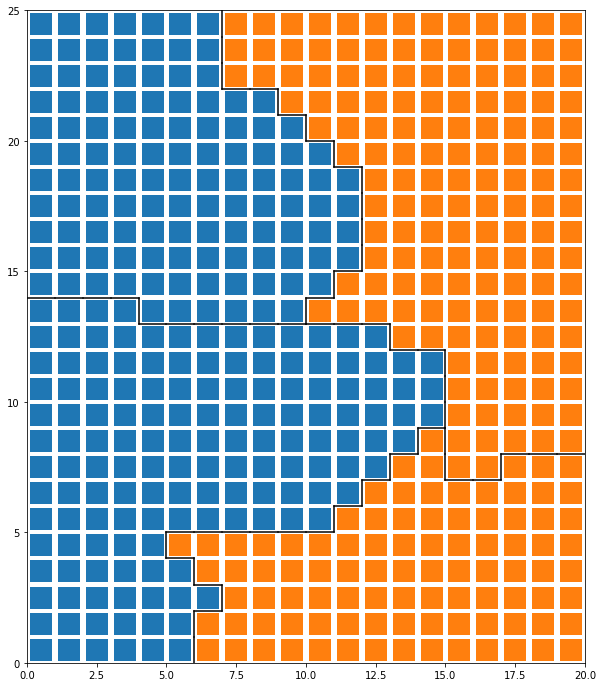

In [56]:

def plot_kmeans(som, n_clusters, seed=0, debug=False):
    """
    Plots the SOM where each winning unit is colored according to its label from running k-means on the weights of the SOM.
    """
    d1 = som._neigx.shape[0]
    d2 = som._neigy.shape[0]
    rweights = som.get_weights().reshape(d1*d2,-1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=seed).fit(rweights)
    labels = kmeans.labels_
    plot_with_labelling(som,None,labels,debug=False)

def plot_hierarchical(som, n_clusters, n_colorings, linkage_method='single'):
    """
    Computes a hierarchical clustering with n_clusters number of clusters, and plots the
    cut-tree between n_colorings and n_clusters.
    """
    assert(n_colorings <= n_clusters)
    d1 = som._neigx.shape[0]
    d2 = som._neigy.shape[0]
    rweights = som.get_weights().reshape(d1*d2,-1)
    Z = linkage(rweights, 'ward') # the clustering
    cuttree = cut_tree(Z,n_clusters=[n_colorings,n_clusters])
    coloring_labels = cuttree.T[0]
    border_labels = cuttree.T[1]
    plot_with_labelling(som,border_labels,coloring_labels,debug=False)
plot_hierarchical(chainlink_som_small, 4, 2)

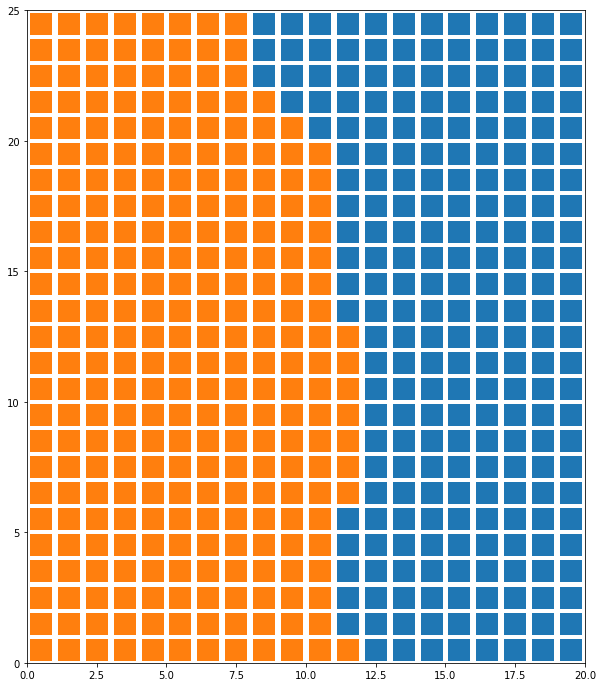

In [53]:
plot_kmeans(chainlink_som_small, 2)
